# Titanic - Machine Learning from Disaster
https://www.kaggle.com/competitions/titanic


In [983]:
# Score: 0.79665 - place 556 from 13970

In [984]:
# imports
import pandas as pd
import numpy as np
import re

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

# settings
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 50)

In [985]:
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler



## Load data

In [986]:
# Load dataset
train_filename = "dataset/train.csv"
test_filename = "dataset/test.csv"

titanic_df = pd.read_csv(train_filename, index_col="PassengerId").reset_index()
test_titanic_df = pd.read_csv(test_filename, index_col="PassengerId").reset_index()
titanic_df.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


In [987]:
titanic_df["Pclass"] = -titanic_df["Pclass"]
test_titanic_df["Pclass"] = -test_titanic_df["Pclass"]

In [988]:
num_cols = ["Age", "Fare"]
cat_cols = ["Pclass", "Embarked", "Sex", ]
bin_cols = [] # 0/1
titanic_df["Fare"] = titanic_df["Fare"].fillna(0)
test_titanic_df["Fare"] = test_titanic_df["Fare"].fillna(0)
titanic_df.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

## Preprocessing dataset

In [989]:
# Fillna "Embarked" - max count "Embarked"
pop_embarked = titanic_df["Embarked"].value_counts().index[0]
titanic_df["Embarked"] = titanic_df["Embarked"].fillna(pop_embarked);

test_titanic_df["Embarked"] = test_titanic_df["Embarked"].fillna(pop_embarked);

In [990]:
# The passenger's name gives additional information (Mr, Mrs, Miss, Dr, Countess, Master, etc)
# Add type_name
titanic_df["type_name"] = titanic_df["Name"].str.split(",").str[1].str.split(".").str[0].str.strip()
test_titanic_df["type_name"] = test_titanic_df["Name"].str.split(",").str[1].str.split(".").str[0].str.strip()

cat_cols += ["type_name"]


In [991]:
# TODO
# Group type_name
# ['Mr', 'Mrs', 'Miss', 'Master', 'Don', 'Rev', 'Dr', 'Mme', 'Ms','Major', 'Lady', 'Sir', 'Mlle', 'Col', 'Capt', 'the Countess', 'Jonkheer', 'Dona']

In [992]:
# Fill Na Age - median value age from type name (train + test) 
# median_age_by_type_name = titanic_df.groupby('type_name')["Age"].agg("median").to_dict()
median_age_by_type_name = pd.concat([ titanic_df[["type_name", "Age"]], test_titanic_df[["type_name", "Age"]] ], ignore_index=True).groupby('type_name')["Age"].agg("median").to_dict() 
titanic_df["Age"] = np.where(titanic_df["Age"].isnull(),  titanic_df["type_name"].apply(lambda x: median_age_by_type_name[x]), titanic_df["Age"])
test_titanic_df["Age"] = np.where(test_titanic_df["Age"].isnull(),  test_titanic_df["type_name"].apply(lambda x: median_age_by_type_name[x]), test_titanic_df["Age"])

titanic_df["age_sex"] = np.where(titanic_df["Sex"] == "female", titanic_df["Age"], -titanic_df["Age"])
test_titanic_df["age_sex"] = np.where(test_titanic_df["Sex"] == "female", test_titanic_df["Age"], -test_titanic_df["Age"])
num_cols += ["age_sex"]

In [993]:
# Join Formally count relatives  = SibSp(siblings/spouses) + Parch (parents/children)
titanic_df["count_relatives"] = titanic_df["SibSp"] + titanic_df["Parch"]
test_titanic_df["count_relatives"] = test_titanic_df["SibSp"] + test_titanic_df["Parch"]
num_cols += ["count_relatives"]

In [994]:
# Split Cabine
titanic_df["cabin_type"] = titanic_df["Cabin"].str[0]
titanic_df["cabin_number"] = titanic_df["Cabin"].str.findall(r"\d+").str[0].fillna(0).astype(int);
test_titanic_df["cabin_type"] = test_titanic_df["Cabin"].str[0]
test_titanic_df["cabin_number"] = test_titanic_df["Cabin"].str.findall(r"\d+").str[0].fillna(0).astype(int);

cat_cols += ["cabin_type"]

In [995]:
# Collective family genus be together
titanic_df["family_genus"] = titanic_df["Name"].str.split(",").str[0].str.strip()
test_titanic_df["family_genus"] = test_titanic_df["Name"].str.split(",").str[0].str.strip()

In [996]:

def groups_relatives(src_df, num_cols):
    """
    Formally count relatives  = SibSp(siblings/spouses) + Parch (parents/children)
    Real relatives/friends = Uniq(One Cabin + One Tickets + group ("family_genus", "Embarked", "Pclass") + group (["family_genus", "Fare"]))
    
    Groups:
        - One Cabin
        - One Tickets
        - One family + class ("family_genus", "Embarked", "Pclass") 
        - One family + Fare ("family_genus", "Fare")
    
    Calc:
        - Percentage of survivors in each group
        - Size of group
        - Mean age in group
        - Mean fare in group
    
    """
    number_columns = num_cols.copy()
    df = src_df.copy()

    
#     # Disable group by one Cabin - many NaN
#     # Group by One Cabin
#     # Prc Survived in One Cabin. other survived from this cabine (prc all survied - this person )
#     df["prc_survived_one_cabin"] = df.groupby(["cabin_type", "cabin_number"])["Survived"].transform(lambda x: (x.sum()-x)/(x.count()-1)).fillna(-1)
#     # Size group in One Cabin 
#     df["size_group_one_cabin"] = df.groupby(["cabin_type", "cabin_number"])["family_genus"].transform("count")
#     # Mean Age in One Cabin 
#     df["mean_age_one_cabin"] = df.groupby(["cabin_type", "cabin_number"])["Age"].transform("mean")
#     # Mean Fare in One Cabin 
#     df["mean_fare_one_cabin"] = df.groupby(["cabin_type", "cabin_number"])["Fare"].transform("mean")

#     number_columns += ["mean_age_one_cabin", "mean_fare_one_cabin", "size_group_one_cabin", "prc_survived_one_cabin"]


    # Group by One Family ["family_genus", "Embarked", "Pclass"]
    # Prc Survived in One Family. other survived from this cabine (prc all survied - this person )
    df["prc_survived_one_family"] = df.groupby(["family_genus", "Embarked", "Pclass"])["Survived"].transform(lambda x: (x.sum()-x)/(x.count()-1)).fillna(-1)
    # Size group in One Family 
    df["size_group_one_family"] = df.groupby(["family_genus", "Embarked", "Pclass"])["family_genus"].transform("count")
    # Mean Age in One Family 
    df["mean_age_one_family"] = df.groupby(["family_genus", "Embarked", "Pclass"])["Age"].transform("mean")
    # Mean Fare in One Family 
    df["mean_fare_one_family"] = df.groupby(["family_genus", "Embarked", "Pclass"])["Fare"].transform("mean")

    number_columns += ["mean_age_one_family", "mean_fare_one_family", "size_group_one_family", "prc_survived_one_family"]




    # Group by One Family+Class ["family_genus", "Pclass", "Fare"]
    # Prc Survived in One Family+Class. other survived from this cabine (prc all survied - this person )
    df["prc_survived_one_family_class"] = df.groupby(["family_genus", "Pclass", "Fare"])["Survived"].transform(lambda x: (x.sum()-x)/(x.count()-1)).fillna(-1)
    # Size group in One Family+Class 
    df["size_group_one_family_class"] = df.groupby(["family_genus", "Pclass", "Fare"])["family_genus"].transform("count")
    # Mean Age in One Family+Class 
    df["mean_age_one_family_class"] = df.groupby(["family_genus", "Pclass", "Fare"])["Age"].transform("mean")
    # Mean Age in One Family+Class 
    df["mean_fare_one_family_class"] = df.groupby(["family_genus", "Pclass", "Fare"])["Fare"].transform("mean")

    number_columns += ["mean_age_one_family_class", "mean_fare_one_family_class", "size_group_one_family_class", "prc_survived_one_family_class"]

    # Group by One Ticket
    # Prc Survived in One Ticket. other survived from this cabine (prc all survied - this person )
    df["prc_survived_one_ticket"] = df.groupby(["Ticket"])["Survived"].transform(lambda x: (x.sum()-x)/(x.count()-1)).fillna(-1)
    # Size group in One Ticket
    df["size_group_one_ticket"] = df.groupby(["Ticket"])["family_genus"].transform("count")
    # Mean Age in One Ticket
    df["mean_age_one_ticket"] = df.groupby(["Ticket"])["Age"].transform("mean")
    # Mean Age in One Ticket
    df["mean_fare_one_ticket"] = df.groupby(["Ticket"])["Fare"].transform("mean")

    number_columns += ["mean_age_one_ticket", "mean_fare_one_ticket", "size_group_one_ticket", "prc_survived_one_ticket"]

    return df, number_columns

titanic_df, num_cols = groups_relatives(titanic_df, num_cols)
test_titanic_df["Survived"] = 0
test_titanic_df, _ = groups_relatives(test_titanic_df, num_cols)
# titanic_df[titanic_df["Cabin"] == "F2"]


In [997]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
titanic_df["Sex"] = -label_encoder.fit_transform(titanic_df["Sex"] )
test_titanic_df["Sex"] = -label_encoder.fit_transform(test_titanic_df["Sex"] )

# Encoder data

In [998]:
x_data = titanic_df[num_cols + cat_cols + bin_cols + ["Survived", "PassengerId"]].copy().sort_index()
x_data_test = test_titanic_df[num_cols + cat_cols + bin_cols + ["Survived", "PassengerId"]].copy().sort_index()
x_data.shape, x_data_test.shape

((891, 27), (418, 27))

In [999]:
x_data.isna().sum()

Age                                0
Fare                               0
age_sex                            0
count_relatives                    0
mean_age_one_cabin               687
mean_fare_one_cabin              687
size_group_one_cabin             687
prc_survived_one_cabin           687
mean_age_one_family                0
mean_fare_one_family               0
size_group_one_family              0
prc_survived_one_family            0
mean_age_one_family_class          0
mean_fare_one_family_class         0
size_group_one_family_class        0
prc_survived_one_family_class      0
mean_age_one_ticket                0
mean_fare_one_ticket               0
size_group_one_ticket              0
prc_survived_one_ticket            0
Pclass                             0
Embarked                           0
Sex                                0
type_name                          0
cabin_type                       687
Survived                           0
PassengerId                        0
d

In [1000]:
x_data.shape, x_data_test.shape, x_trans.shape, len(fit_cat_pipeline.get_feature_names_out())

((891, 27), (418, 27), (891, 55), 53)

In [1001]:

categorical_pipeline = make_pipeline(OneHotEncoder(handle_unknown="ignore", sparse=False))
categorical_columns = ["Embarked", "type_name", "cabin_type"]

preprocessing_categorical = ColumnTransformer([
                                             ("cat_ohe_", categorical_pipeline, categorical_columns),
                                             #('src', 'passthrough', ["Age", "Fare", "count_relatives", "mean_age_one_family", "size_group_one_family", "prc_survived_one_family", "Pclass", "Sex", "Survived"]),
                                            ],
                  verbose_feature_names_out = True, remainder='passthrough'
)
fit_cat_pipeline = preprocessing_categorical.fit(x_data)
x_trans = fit_cat_pipeline.transform(x_data)


x_data = pd.DataFrame(x_trans, columns=fit_cat_pipeline.get_feature_names_out())
x_data_test = pd.DataFrame(fit_cat_pipeline.transform(x_data_test), columns=fit_cat_pipeline.get_feature_names_out())
x_data_test["remainder__PassengerId"] = x_data_test["remainder__PassengerId"].astype("int")
x_data.shape, x_data_test.shape



((891, 53), (418, 53))

# Data analysis
## Correlation matrix

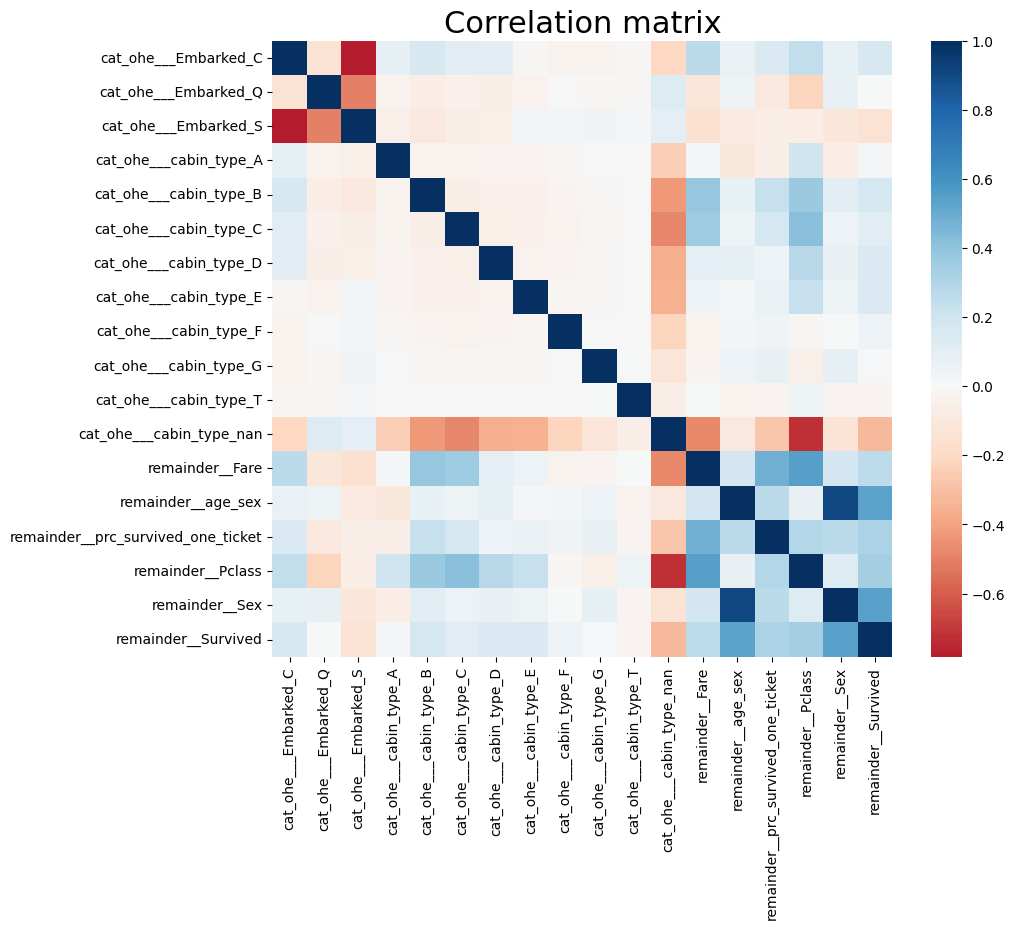

In [1002]:
correlation = x_data[["cat_ohe___Embarked_C","cat_ohe___Embarked_Q","cat_ohe___Embarked_S","cat_ohe___cabin_type_A","cat_ohe___cabin_type_B","cat_ohe___cabin_type_C","cat_ohe___cabin_type_D","cat_ohe___cabin_type_E","cat_ohe___cabin_type_F","cat_ohe___cabin_type_G","cat_ohe___cabin_type_T","cat_ohe___cabin_type_nan","remainder__Fare","remainder__age_sex","remainder__prc_survived_one_ticket","remainder__Pclass","remainder__Sex","remainder__Survived",]].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(
    correlation,
    xticklabels=correlation.columns,
    yticklabels=correlation.columns,
    cmap="RdBu",
    center=0,
)

plt.title("Correlation matrix", fontsize=22)
plt.show()

# Create models

## Normalization + split train/test

In [1003]:
clear_y_data = x_data["remainder__Survived"].copy().sort_index()
x_data = x_data.drop(columns=["remainder__Survived"])
x_data_test = x_data_test.drop(columns=["remainder__Survived"])
# Converting to [0., 1.]
y_data = np.array([[1-weight, weight] for weight in clear_y_data])

x_data.shape, y_data.shape, clear_y_data.shape

((891, 52), (891, 2), (891,))

In [1004]:
# Разбиваем данные на train, test, val
from sklearn.model_selection import train_test_split


x_train, x_val, y_train, y_val, clear_y_train, clear_y_val = train_test_split(x_data[["cat_ohe___Embarked_C","cat_ohe___Embarked_Q","cat_ohe___Embarked_S","cat_ohe___cabin_type_A","cat_ohe___cabin_type_B","cat_ohe___cabin_type_C","cat_ohe___cabin_type_D","cat_ohe___cabin_type_E","cat_ohe___cabin_type_F","cat_ohe___cabin_type_G","cat_ohe___cabin_type_T","cat_ohe___cabin_type_nan","remainder__Fare","remainder__age_sex","remainder__prc_survived_one_ticket","remainder__Pclass","remainder__Sex",]], y_data, clear_y_data, test_size=0.05, shuffle=True)
# x_train, x_val, y_train, y_val, clear_y_train, clear_y_val = train_test_split(x_data, y_data, clear_y_data, test_size=0.05, shuffle=True)
# x_val, x_test, y_val, y_test = train_test_split(x_val, y_val, test_size=0.5, shuffle=True)

x_train.shape, x_val.shape, y_train.shape, y_val.shape, clear_y_train.shape, clear_y_val.shape
#, x_test.shape, y_test.shape, 

((846, 17), (45, 17), (846, 2), (45, 2), (846,), (45,))

In [1]:
# Стратификационная выборка с логистической регрессией 
# from sklearn.model_selection import StratifiedShuffleSplit # Поделим train_data на обучающую и валидационную выборку 
#                                                            # Таким образом, чтобы доля тех, кто ушёл и кто остался 
#                                                            #в обоих наборах была одинаковой
# split = StratifiedShuffleSplit(n_splits = 1, test_size = 0.3, random_state = 42)

# for train_idx, test_idx in split.split(train_data, train_data["Churn"]):
#     strat_train_set = train_data.loc[train_idx]
#     strat_test_set = train_data.loc[test_idx]
#     y_strat_train = y.loc[train_idx]
#     y_strat_test = y.loc[test_idx]


In [1005]:

x_train_normalize = x_train.copy()
x_val_normalize = x_val.copy()
# normal_num_cols = ['remainder__Age', 'remainder__Fare']
normal_num_cols = ['remainder__Fare']

age_fare_scaler = StandardScaler()
age_fare_scaler.fit(x_train_normalize[normal_num_cols])


x_train_normalize[normal_num_cols] = age_fare_scaler.transform(x_train_normalize[normal_num_cols])
x_val_normalize[normal_num_cols] = age_fare_scaler.transform(x_val_normalize[normal_num_cols])
x_data_test[normal_num_cols] = age_fare_scaler.transform(x_data_test[normal_num_cols])

x_train_normalize.shape, x_val_normalize.shape


((846, 17), (45, 17))

## Create and fit Tensorflow model

In [1006]:
import tensorflow
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout


Epoch 1/20
282/282 [==============================] - 9s 23ms/step - loss: 0.6413 - accuracy: 0.6939 - auc: 0.7457 - precision: 0.6939 - recall: 0.6939 - val_loss: 0.8126 - val_accuracy: 0.6222 - val_auc: 0.7121 - val_precision: 0.6222 - val_recall: 0.6222
Epoch 2/20
282/282 [==============================] - 5s 18ms/step - loss: 0.5779 - accuracy: 0.7423 - auc: 0.7908 - precision: 0.7423 - recall: 0.7423 - val_loss: 0.6983 - val_accuracy: 0.6444 - val_auc: 0.7225 - val_precision: 0.6444 - val_recall: 0.6444
Epoch 3/20
282/282 [==============================] - 5s 18ms/step - loss: 0.5769 - accuracy: 0.7411 - auc: 0.7856 - precision: 0.7411 - recall: 0.7411 - val_loss: 0.6591 - val_accuracy: 0.7333 - val_auc: 0.7348 - val_precision: 0.7333 - val_recall: 0.7333
Epoch 4/20
282/282 [==============================] - 5s 19ms/step - loss: 0.5585 - accuracy: 0.7624 - auc: 0.7957 - precision: 0.7624 - recall: 0.7624 - val_loss: 0.8286 - val_accuracy: 0.5778 - val_auc: 0.6079 - val_precision: 

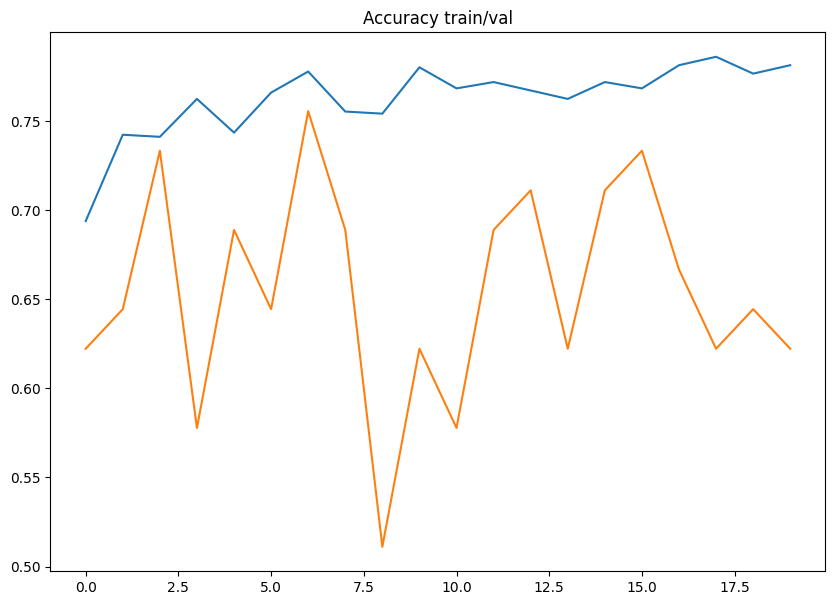

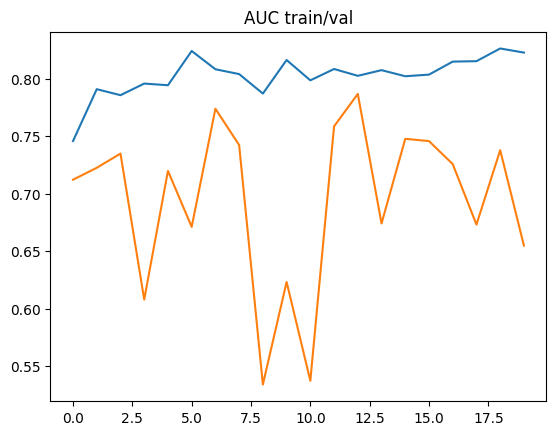

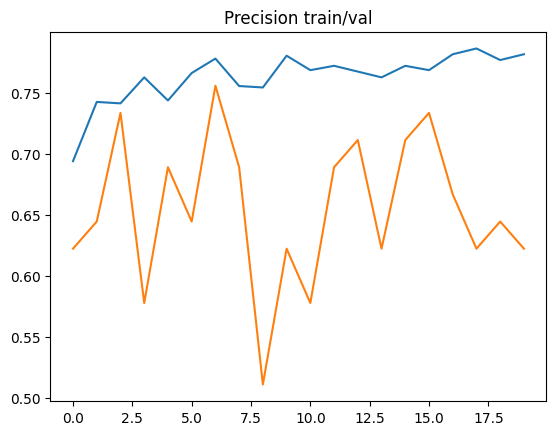

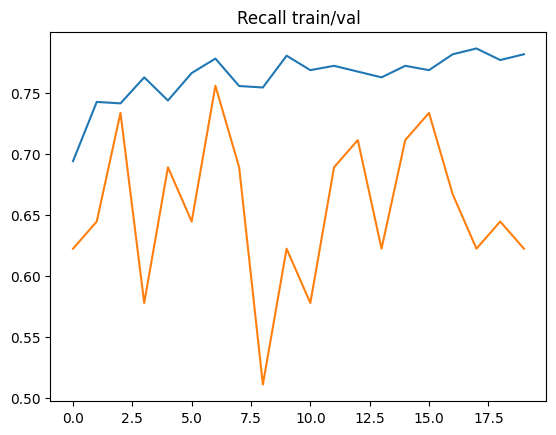

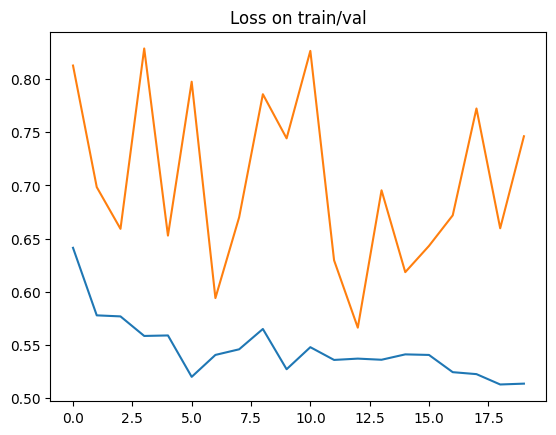

In [1007]:
model = Sequential()
model.add(Dense(800, input_shape=(x_train_normalize.shape[1:]), activation="relu"))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(Dense(400, activation="relu")) 
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(Dense(200, activation="relu"))
model.add(Dropout(0.1))
model.add(BatchNormalization())
model.add(Dense(50, activation="relu"))
model.add(Dropout(0.1))
model.add(Dense(2, activation="softmax"))
model.compile( optimizer="Nadam", loss="binary_crossentropy", metrics=["accuracy", "AUC", "Precision", "Recall"] ) 

history = model.fit( x_train_normalize, y_train, epochs=20, validation_data=(x_val_normalize, y_val), verbose=True, batch_size=3)

plt.figure(figsize=(10,7))

plt.plot(history.history["accuracy"], label="accuracy")
plt.plot(history.history["val_accuracy"], label="val_accuracy")
plt.title("Accuracy train/val")
plt.show()

plt.plot(history.history["auc"], label="auc")
plt.plot(history.history["val_auc"], label="val_auc")
plt.title("AUC train/val")
plt.show()


plt.plot(history.history["precision"], label="precision")
plt.plot(history.history["val_precision"], label="val_precision")
plt.title("Precision train/val")
plt.show()

plt.plot(history.history["recall"], label="recall")
plt.plot(history.history["val_recall"], label="val_recall")
plt.title("Recall train/val")
plt.show()



plt.plot(history.history["loss"], label="loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.title("Loss on train/val")
plt.show()

## Fit models sklearn
Create and fit models sklearn:

    - AdaBoostClassifier
    - GradientBoostingClassifier
    - DecisionTreeClassifier
    - RandomForestClassifier
    - ExtraTreesClassifier
    - HistGradientBoostingClassifier
    - LogisticRegression

In [1008]:
from sklearn.ensemble import AdaBoostClassifier

ada_model = AdaBoostClassifier()
ada_model.fit(x_train_normalize, clear_y_train)

ada_predict_val = ada_model.predict(x_val_normalize)
roc_auc_score(clear_y_val, ada_predict_val)


0.7521008403361344

In [1009]:
from sklearn.ensemble import GradientBoostingClassifier

gradient_model = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0)
gradient_model.fit(x_train_normalize, clear_y_train)

gradient_predict_val = gradient_model.predict(x_val_normalize)
roc_auc_score(clear_y_val, gradient_predict_val)

0.7405462184873951

In [1010]:
from sklearn.tree import DecisionTreeClassifier

decis_model = DecisionTreeClassifier(max_depth=None, min_samples_split=2, random_state=0)
decis_model.fit(x_train_normalize, clear_y_train)
decis_predict_val = decis_model.predict(x_val_normalize)
roc_auc_score(clear_y_val, decis_predict_val)

0.6397058823529411

In [1011]:
from sklearn.ensemble import RandomForestClassifier

forest_model = RandomForestClassifier(n_estimators=10, max_depth=None, min_samples_split=2, random_state=0)
forest_model.fit(x_train_normalize, clear_y_train)
forest_predict_val = forest_model.predict(x_val_normalize)
roc_auc_score(clear_y_val, forest_predict_val)

0.7699579831932774

In [1012]:
from sklearn.ensemble import ExtraTreesClassifier

extra_model = ExtraTreesClassifier(n_estimators=10, max_depth=None, min_samples_split=2, random_state=0)
extra_model.fit(x_train_normalize, clear_y_train)
extra_predict_val = extra_model.predict(x_val_normalize)
roc_auc_score(clear_y_val, extra_predict_val)

0.7048319327731093

In [1013]:
from sklearn.ensemble import HistGradientBoostingClassifier

hist_gradient_model = HistGradientBoostingClassifier(max_iter=100)
hist_gradient_model.fit(x_train_normalize, clear_y_train)
hist_gradient_predict_val = hist_gradient_model.predict(x_val_normalize)
roc_auc_score(clear_y_val, hist_gradient_predict_val)

0.7521008403361344

In [1014]:
from sklearn.linear_model import LogisticRegression

logler_model = LogisticRegression(solver='liblinear', C=4, penalty='l1')
logler_model.fit(x_train_normalize, clear_y_train)
logler_predict_val = logler_model.predict(x_val_normalize)
roc_auc_score(clear_y_val, logler_predict_val)

0.7405462184873951

## Create mean predict from 7 models sklearn + model tensorflow

In [1015]:
from sklearn.ensemble import VotingClassifier
voting_model = VotingClassifier(
    estimators=[
                ('ada_model', ada_model), 
                ('gradient_model', gradient_model), 
                ('decis_model', decis_model), 
                ('forest_model', forest_model), 
                ('extra_model', extra_model), 
                ('logler_model', logler_model),                 
                ('hist_gradient_model', hist_gradient_model), 
               ],    voting='hard')

voting_model.fit(x_train_normalize, clear_y_train)
voting_predict_val = voting_model.predict(x_val_normalize)
roc_auc_score(clear_y_val, voting_predict_val)

0.7521008403361344

In [1016]:
# test_for_model = x_data_test[x_data_test.columns.difference(["remainder__PassengerId"])]
test_for_model = x_data_test[["cat_ohe___Embarked_C","cat_ohe___Embarked_Q","cat_ohe___Embarked_S","cat_ohe___cabin_type_A","cat_ohe___cabin_type_B","cat_ohe___cabin_type_C","cat_ohe___cabin_type_D","cat_ohe___cabin_type_E","cat_ohe___cabin_type_F","cat_ohe___cabin_type_G","cat_ohe___cabin_type_T","cat_ohe___cabin_type_nan","remainder__Fare","remainder__age_sex","remainder__prc_survived_one_ticket","remainder__Pclass","remainder__Sex",]]

tf_predict = model.predict(test_for_model)
gradient_predict = gradient_model.predict(test_for_model)
decis_predict = decis_model.predict(test_for_model)
forest_predict = forest_model.predict(test_for_model)
extra_predict = extra_model.predict(test_for_model)
logler_predict = logler_model.predict(test_for_model)
hist_gradient_predict = hist_gradient_model.predict(test_for_model)

14/14 [==============================] - 0s 3ms/step


In [1017]:

x_data_test["tf_predict"] = [1 if x[1] > x[0] else 0 for x in tf_predict ]
x_data_test["gradient_predict"] = gradient_predict.astype(int)
x_data_test["decis_predict"] = decis_predict.astype(int)
x_data_test["forest_predict"] = forest_predict.astype(int)
x_data_test["extra_predict"] = extra_predict.astype(int)
x_data_test["logler_predict"] = logler_predict.astype(int)
x_data_test["hist_gradient_predict"] = hist_gradient_predict.astype(int)
x_data_test["ensemble_predict"] = np.where(x_data_test[["tf_predict", "gradient_predict", "decis_predict", "forest_predict", "extra_predict", "logler_predict", "hist_gradient_predict"]].mean(axis=1) >= 0.5, 1, 0)

In [1018]:
# Save 1st stage csv
x_data_test[["remainder__PassengerId", "ensemble_predict"]].to_csv("result/stage1_submission.csv", sep=",", index=False, header=["PassengerId","Survived"])

# Based on the predictions of the 1st stage, we update the survival of the group features and re-run the prediction on the test data

In [1019]:
test_titanic_df

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,type_name,age_sex,count_relatives,cabin_type,cabin_number,family_genus,Survived,prc_survived_one_cabin,size_group_one_cabin,mean_age_one_cabin,mean_fare_one_cabin,prc_survived_one_family,size_group_one_family,mean_age_one_family,mean_fare_one_family,prc_survived_one_family_class,size_group_one_family_class,mean_age_one_family_class,mean_fare_one_family_class,prc_survived_one_ticket,size_group_one_ticket,mean_age_one_ticket,mean_fare_one_ticket
0,892,-3,"Kelly, Mr. James",-1,34.50,0,0,330911,7.8292,NaN,Q,Mr,-34.50,0,NaN,0,Kelly,0,NaN,NaN,NaN,NaN,-1.0,1,34.500000,7.829200,-1.0,1,34.500000,7.8292,-1.0,1,34.500000,7.8292
1,893,-3,"Wilkes, Mrs. James (Ellen Needs)",0,47.00,1,0,363272,7.0000,NaN,S,Mrs,47.00,1,NaN,0,Wilkes,0,NaN,NaN,NaN,NaN,-1.0,1,47.000000,7.000000,-1.0,1,47.000000,7.0000,-1.0,1,47.000000,7.0000
2,894,-2,"Myles, Mr. Thomas Francis",-1,62.00,0,0,240276,9.6875,NaN,Q,Mr,-62.00,0,NaN,0,Myles,0,NaN,NaN,NaN,NaN,-1.0,1,62.000000,9.687500,-1.0,1,62.000000,9.6875,-1.0,1,62.000000,9.6875
3,895,-3,"Wirz, Mr. Albert",-1,27.00,0,0,315154,8.6625,NaN,S,Mr,-27.00,0,NaN,0,Wirz,0,NaN,NaN,NaN,NaN,-1.0,1,27.000000,8.662500,-1.0,1,27.000000,8.6625,-1.0,1,27.000000,8.6625
4,896,-3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",0,22.00,1,1,3101298,12.2875,NaN,S,Mrs,22.00,2,NaN,0,Hirvonen,0,NaN,NaN,NaN,NaN,-1.0,1,22.000000,12.287500,-1.0,1,22.000000,12.2875,-1.0,1,22.000000,12.2875
5,897,-3,"Svensson, Mr. Johan Cervin",-1,14.00,0,0,7538,9.2250,NaN,S,Mr,-14.00,0,NaN,0,Svensson,0,NaN,NaN,NaN,NaN,-1.0,1,14.000000,9.225000,-1.0,1,14.000000,9.2250,-1.0,1,14.000000,9.2250
6,898,-3,"Connolly, Miss. Kate",0,30.00,0,0,330972,7.6292,NaN,Q,Miss,30.00,0,NaN,0,Connolly,0,NaN,NaN,NaN,NaN,-1.0,1,30.000000,7.629200,-1.0,1,30.000000,7.6292,-1.0,1,30.000000,7.6292
7,899,-2,"Caldwell, Mr. Albert Francis",-1,26.00,1,1,248738,29.0000,NaN,S,Mr,-26.00,2,NaN,0,Caldwell,0,NaN,NaN,NaN,NaN,-1.0,1,26.000000,29.000000,-1.0,1,26.000000,29.0000,-1.0,1,26.000000,29.0000
8,900,-3,"Abrahim, Mrs. Joseph (Sophie Halaut Easu)",0,18.00,0,0,2657,7.2292,NaN,C,Mrs,18.00,0,NaN,0,Abrahim,0,NaN,NaN,NaN,NaN,-1.0,1,18.000000,7.229200,-1.0,1,18.000000,7.2292,-1.0,1,18.000000,7.2292
9,901,-3,"Davies, Mr. John Samuel",-1,21.00,2,0,A/4 48871,24.1500,NaN,S,Mr,-21.00,2,NaN,0,Davies,0,NaN,NaN,NaN,NaN,0.0,3,20.000000,13.416667,-1.0,1,21.000000,24.1500,-1.0,1,21.000000,24.1500


In [1020]:
# For 2 stage
test_titanic_df = test_titanic_df.merge(x_data_test[["remainder__PassengerId", "ensemble_predict"]], left_on='PassengerId', right_on='remainder__PassengerId')
# For 3 stage
# test_titanic_df = test_titanic_df.merge(second_stage_x_data[["remainder__PassengerId", "ensemble_predict"]], left_on='PassengerId', right_on='remainder__PassengerId')

test_titanic_df["Survived"] = test_titanic_df["ensemble_predict"]
# test_titanic_df.head(5)
# test_titanic_df

In [1021]:
test_titanic_df = test_titanic_df.drop(columns=['remainder__PassengerId', 'ensemble_predict'])

In [1022]:
union_titanic_df = pd.concat([titanic_df, test_titanic_df], ignore_index=True)
titanic_df.shape, test_titanic_df.shape, union_titanic_df.shape

((891, 34), (418, 34), (1309, 34))

In [1023]:
# Create groups features
union_titanic_df, _ = groups_relatives(union_titanic_df, num_cols)

In [1024]:
second_stage_test_titanic_df =  union_titanic_df.loc[union_titanic_df['PassengerId'].isin(test_titanic_df["PassengerId"])]

In [1026]:
second_stage_x_data = second_stage_test_titanic_df[num_cols + cat_cols + bin_cols + ["Survived", "PassengerId"]].copy().sort_index()
second_stage_x_data.shape

(418, 27)

In [1027]:
second_stage_x_data = pd.DataFrame(fit_cat_pipeline.transform(second_stage_x_data), columns=fit_cat_pipeline.get_feature_names_out())
second_stage_x_data.shape

(418, 53)

In [1028]:
# Normalization using age_fare_scaler
second_stage_x_data[normal_num_cols] = age_fare_scaler.transform(second_stage_x_data[normal_num_cols])

In [1029]:
# test_data_stage_2_for_model = second_stage_x_data[second_stage_x_data.columns.difference(["remainder__PassengerId"])][x_val_normalize.columns]
test_data_stage_2_for_model = second_stage_x_data[x_val_normalize.columns][["cat_ohe___Embarked_C","cat_ohe___Embarked_Q","cat_ohe___Embarked_S","cat_ohe___cabin_type_A","cat_ohe___cabin_type_B","cat_ohe___cabin_type_C","cat_ohe___cabin_type_D","cat_ohe___cabin_type_E","cat_ohe___cabin_type_F","cat_ohe___cabin_type_G","cat_ohe___cabin_type_T","cat_ohe___cabin_type_nan","remainder__Fare","remainder__age_sex","remainder__prc_survived_one_ticket","remainder__Pclass","remainder__Sex",]]


second_stage_x_data["tf_predict"] = [1 if x[1] > x[0] else 0 for x in model.predict(test_data_stage_2_for_model) ]
second_stage_x_data["gradient_predict"] = gradient_model.predict(test_data_stage_2_for_model)
second_stage_x_data["decis_predict"] = decis_model.predict(test_data_stage_2_for_model)
second_stage_x_data["forest_predict"] = forest_model.predict(test_data_stage_2_for_model)
second_stage_x_data["extra_predict"] = extra_model.predict(test_data_stage_2_for_model)
second_stage_x_data["logler_predict"] = logler_model.predict(test_data_stage_2_for_model)
second_stage_x_data["hist_gradient_predict"] = hist_gradient_model.predict(test_data_stage_2_for_model)



second_stage_x_data["ensemble_predict"] = np.where(second_stage_x_data[["tf_predict", "gradient_predict", "decis_predict", "forest_predict", "extra_predict", "logler_predict", "hist_gradient_predict"]].mean(axis=1) >= 0.5, 1, 0)

14/14 [==============================] - 0s 3ms/step
